## Lab: Cart Pole Demo 2 using OpenAI gym
## Policy Gradient

### University of Virginia
### Reinforcement Learning
#### Last updated: March 4, 2024

#### Bruce McGregor (BM3PK)
#### November 14, 2025
---


#### Instructions:  

Carefully read the notes below and run the provided code. Answer each question clearly and show all results.

#### TOTAL POINTS: 12

---

### First a Refresh

Let's briefly review the content from Demo 1: Basics and Simple Policy

We revisit the CartPole problem.

We will work with the fork [gymnasium](https://gymnasium.farama.org/) which maintains OpenAI gym.  

The *simple policy* didn't perform very well: the average reward was about 42.

We want to see if we can do better using a Policy Gradient algorithm.

### Setup and First Steps

In [1]:
! pip install gymnasium

In [2]:
! pip install renderlab

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import renderlab as rl

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Load the environment

In [4]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")
state = env.reset(seed=314)

Given the state, we take an action. The next state comes from the environment, which is encoded in `gym`.

Components:   
[0]: cart horizontal position (0.0 = center)  
[1]: velocity (positive means right)  
[2]: angle of the pole (0.0 = vertical)  
[3]: pole's angular velocity (positive means clockwise)

In [5]:
state

(array([0.04225422, 0.02126478, 0.02520455, 0.00700802], dtype=float32), {})

In [6]:
# state space number of components
env.observation_space.shape[0]

4

The action space consists of two options:

[0]: move cart left   
[1]: move cart right

In [7]:
env.action_space

Discrete(2)

Let's take an action, draw a sample and look at the results.

In [8]:
# move right
action = 1

# take a step and get next state, reward from environment
state, reward, terminated, truncated, info = env.step(action)
done = terminated or truncated

print('state', state)
print('reward', reward)
print('done', done)
print('info', info)

state [ 0.04267951  0.21601637  0.02534471 -0.27761722]
reward 1.0
done False
info {}


**Reward and Episode**  

For each time step that the cart keeps the pole balanced, it earns reward 1.

If the pole tilts too much or if the cart moves off screen, `reward=0` and `done=True` (the episode will end).

When the episode ends, a new episode may begin. The process learns cumulatively from each episode.

**Simple policy**:  

When the pole leans left (negative angle), move left. When the pole leans right (positive angle), move right.

Run many episodes and visualize their reward distribution.

In [9]:
def simple_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

num_episodes = 1000
num_steps = 1000
rewards = []

for episode in range(num_episodes):
    ep_reward = 0
    state = env.reset()[0]
    for step in range(num_steps):
        #print(state)
        action = simple_policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        ep_reward += reward
        if done:
            break

    rewards.append(ep_reward)

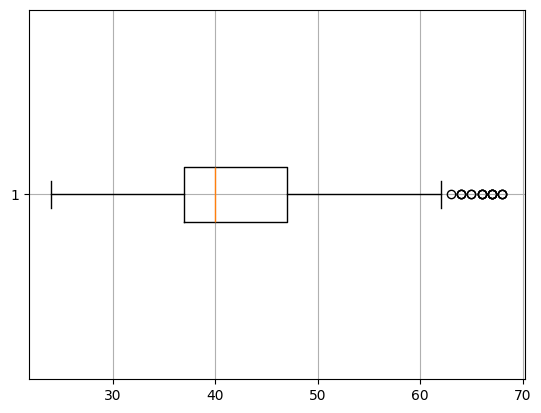

In [10]:
plt.boxplot(rewards, vert=False)
plt.grid()
plt.show()

In [11]:
print('mean reward:', np.mean(rewards))

mean reward: 41.993


### Neural Network Policy

Now we try a more sophisticated policy: let's use a neural network.

The network will take **state as input**. The output node will contain the probability of the actions.

Since there are two actions (left, right), we require one output node.  
Node will output probability of right (so prob of left is implied).

For simplicity, we will use one hidden layer.

Number of nodes in hidden layer is a hyperparameter.

---


#### 1) **Define a neural network model for the policy.**

**(POINTS: 1)**  
It should have appropriate dimensions for the input and output layer. Print a summary of the model that shows the output shape for each layer.

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the number of nodes in the hidden layer as a hyperparameter
HIDDEN_LAYER_SIZE = 32 #32 gives better results than 64

# Define the neural network model using PyTorch
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(observation_space_size, HIDDEN_LAYER_SIZE) # Input layer to hidden layer
        self.relu = nn.ReLU() # ReLU activation
        self.fc2 = nn.Linear(HIDDEN_LAYER_SIZE, 1) # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid() # Sigmoid activation for probability of action 1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        action_prob = self.sigmoid(x)
        return action_prob

# Instantiate the model
model = PolicyNetwork(env.observation_space.shape[0])

print(model)

PolicyNetwork(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


#### 2) Is **REINFORCE** a Monte Carlo method? Explain your answer.

**(POINTS: 1)**

Yes, REINFORCE is a Monte Carlo method. It collects the rewards from the entire episode before calculating the discounted return. This return is then used to update the policy parameters using gradient ascent.



#### 3) **Training and Evaluating the Policy Model.**

Define functions to train and evaluate the model. Your work should include the steps below among others. Note that subtasks are numbered [1], [2], etc. and are worth one point each.

- **(POINTS: 2)** Write a function `play_single_step` to evolve the system one step. It should also compute the gradient of the loss function. Test that it works properly and print the next state.  

- **(POINTS: 2)** Write a function that runs multiple episodes, calling the `play_single_step` function. It should also compute and store the reward and gradient for each time step of each episode. Test that it works properly and print the rewards from running two episodes each with five time steps.
- **(POINTS: 3)** Define and run a training loop using the REINFORCE algorithm that [1] runs multiple episodes, [2] computes discounted rewards, and [3] updates the parameters with gradient ascent. Run a sufficient number of episodes and time steps to see an average reward of at least 75 in the `evaluate` step that follows. Show evidence that the training loop is working, such as printing the total discounted rewards per episode.
- **(POINTS: 3)** Now that the model is trained, you can use it as the policy and evaluate performance. Write code that [1] applies the model as the policy, [2] runs 1000 episodes and [3] computes the minimum reward, average reward, and maximum reward across the episodes. Discuss how the average reward from REINFORCE compares to the average reward from the simple policy from Cart Pole lab 1.

---

In [25]:
def play_single_step(state, model, env):
    # Convert state to PyTorch tensor
    state_tensor = torch.from_numpy(state).float().unsqueeze(0)

    # Get action probability from the model
    action_prob = model(state_tensor) #calling model automatically runs the forward() function

    # Sample an action from the probability distribution
    # For a single output representing P(action=1) is right, P(action=0) is left = 1 - P(action=1)
    action_distribution = torch.distributions.Categorical(torch.cat([1 - action_prob, action_prob], dim=1))
    action = action_distribution.sample()

    # Calculate the log probability of the chosen action
    log_prob = action_distribution.log_prob(action)

    # Take the chosen action in the environment
    next_state, reward, terminated, truncated, info = env.step(action.item())
    done = terminated or truncated

    # For REINFORCE, the "loss" for a single step is the negative log probability of the action
    # We will multiply this by the discounted reward later in the training loop
    loss = -log_prob

    return next_state, reward, done, loss, log_prob

In [49]:
# Test the play_single_step function
# Reset the environment to get an initial state
state = env.reset(seed=42)[0]

# Play a single step
next_state, reward, done, loss, log_prob = play_single_step(state, model, env)

# Print the next state
print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)
print("Loss (negative log probability):", loss)
print("Log Probability:", log_prob)

Next State: [ 0.02727336 -0.20172954  0.03625453  0.32351476]
Reward: 1.0
Done: False
Loss (negative log probability): tensor([0.6105], grad_fn=<NegBackward0>)
Log Probability: tensor([-0.6105], grad_fn=<SqueezeBackward1>)


In [50]:
#play_multiple_steps
def play_multiple_episodes(model, env, num_episodes, num_steps):
    all_rewards = []
    all_losses = []

    for episode in range(num_episodes):
        episode_rewards = []
        episode_losses = []
        state = env.reset(seed=episode)[0] # Use episode number as seed for reproducibility
        done = False
        step_count = 0

        while not done and step_count < num_steps:
            next_state, reward, done, loss, log_prob = play_single_step(state, model, env)
            episode_rewards.append(reward)
            episode_losses.append(loss)
            state = next_state
            step_count += 1

        all_rewards.append(episode_rewards)
        all_losses.append(episode_losses)

    return all_rewards, all_losses

In [52]:
# Test the play_multiple_episodes function
num_test_episodes = 2
num_test_steps = 5

test_rewards, test_losses = play_multiple_episodes(model, env, num_test_episodes, num_test_steps)

# Print the rewards from the test run
print("Rewards from test episodes:")
for i, episode_rewards in enumerate(test_rewards):
    print(f"Episode {i+1}: {episode_rewards}")

# Also print the losses to see their structure
print("\nLosses from test episodes:")
for i, episode_losses in enumerate(test_losses):
  print(f"Episode {i+1}: {episode_losses}")

Rewards from test episodes:
Episode 1: [1.0, 1.0, 1.0, 1.0, 1.0]
Episode 2: [1.0, 1.0, 1.0, 1.0, 1.0]

Losses from test episodes:
Episode 1: [tensor([0.7821], grad_fn=<NegBackward0>), tensor([0.6089], grad_fn=<NegBackward0>), tensor([0.6121], grad_fn=<NegBackward0>), tensor([0.7780], grad_fn=<NegBackward0>), tensor([0.7796], grad_fn=<NegBackward0>)]
Episode 2: [tensor([0.7922], grad_fn=<NegBackward0>), tensor([0.6044], grad_fn=<NegBackward0>), tensor([0.6035], grad_fn=<NegBackward0>), tensor([0.6068], grad_fn=<NegBackward0>), tensor([0.7815], grad_fn=<NegBackward0>)]


## TRAINING LOOP

I ran the training loop two times. The first is using normalized rewards, anad the second without normalized rewards


In [32]:
# training loop using normalized rewards
def discount_rewards(rewards, gamma=0.99):  #helper function to calculate discounted rewards
    discounted_reward = 0
    discounted_rewards = []
    for reward in reversed(rewards):
        discounted_reward = reward + gamma * discounted_reward
        discounted_rewards.append(discounted_reward)
    discounted_rewards.reverse()
    return torch.tensor(discounted_rewards, dtype=torch.float32)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_policy(model, env, optimizer, num_training_episodes, max_steps_per_episode, gamma=0.99, use_normalization=True):
    for episode in range(num_training_episodes):
        episode_rewards = []
        episode_losses = [] # These are the negative log probabilities

        state = env.reset(seed=episode)[0]
        done = False
        step_count = 0

        while not done and step_count < max_steps_per_episode:
            next_state, reward, done, loss, log_prob = play_single_step(state, model, env)
            episode_rewards.append(reward)
            episode_losses.append(loss)
            state = next_state
            step_count += 1

        # Calculate discounted rewards for the episode
        discounted_returns = discount_rewards(episode_rewards, gamma)

        # Normalize discounted rewards for training stability
        if use_normalization:
            discounted_returns = (discounted_returns - discounted_returns.mean()) / (discounted_returns.std() + 1e-9)

        # Calculate the policy loss for the episode
        # The loss is the sum of (negative log probability * discounted return) for each step
        policy_loss = torch.cat(episode_losses).squeeze() * discounted_returns
        policy_loss = policy_loss.mean() # Take the mean to average the loss over steps

        # Perform gradient ascent (minimize the negative policy loss)
        optimizer.zero_grad() # Clear previous gradients
        policy_loss.backward() # Compute gradients
        optimizer.step() # Update model parameters

        # Print progress
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_training_episodes}, Total steps: {step_count}, Total reward: {sum(episode_rewards)}, Policy Loss: {policy_loss.item():.4f}")

    print("Training finished.")


## Run training without normalization




In [34]:
# Instantiate a new model for training without normalization
model_no_norm = PolicyNetwork(env.observation_space.shape[0])

# Instantiate a new optimizer for the new model
optimizer_no_norm = optim.Adam(model_no_norm.parameters(), lr=0.01)

# Set training parameters
num_training_episodes = 1000
max_steps_per_episode = 500

# Train the model without normalization
print("Starting training without normalization...")
train_policy(model_no_norm, env, optimizer_no_norm, num_training_episodes, max_steps_per_episode, use_normalization=False)

Starting training without normalization...
Episode 100/1000, Total steps: 21, Total reward: 21.0, Policy Loss: 6.6692
Episode 200/1000, Total steps: 30, Total reward: 30.0, Policy Loss: 7.5851
Episode 300/1000, Total steps: 82, Total reward: 82.0, Policy Loss: 16.4352
Episode 400/1000, Total steps: 112, Total reward: 112.0, Policy Loss: 24.3651
Episode 500/1000, Total steps: 38, Total reward: 38.0, Policy Loss: 7.1896
Episode 600/1000, Total steps: 197, Total reward: 197.0, Policy Loss: 30.5856
Episode 700/1000, Total steps: 273, Total reward: 273.0, Policy Loss: 32.8052
Episode 800/1000, Total steps: 189, Total reward: 189.0, Policy Loss: 26.1525
Episode 900/1000, Total steps: 121, Total reward: 121.0, Policy Loss: 19.0503
Episode 1000/1000, Total steps: 238, Total reward: 238.0, Policy Loss: 28.1217
Training finished.


### Run training with normalization




In [36]:
# Instantiate a new model for training with normalization
model_with_norm = PolicyNetwork(env.observation_space.shape[0])

# Instantiate a new optimizer for the new model
optimizer_with_norm = optim.Adam(model_with_norm.parameters(), lr=0.01)

# Set training parameters (same as before)
num_training_episodes = 1000
max_steps_per_episode = 500

# Train the model with normalization
print("Starting training with normalization...")
train_policy(model_with_norm, env, optimizer_with_norm, num_training_episodes, max_steps_per_episode, use_normalization=True)

Starting training with normalization...
Episode 100/1000, Total steps: 37, Total reward: 37.0, Policy Loss: -0.0014
Episode 200/1000, Total steps: 413, Total reward: 413.0, Policy Loss: -0.0050
Episode 300/1000, Total steps: 500, Total reward: 500.0, Policy Loss: -0.0047
Episode 400/1000, Total steps: 500, Total reward: 500.0, Policy Loss: 0.0145
Episode 500/1000, Total steps: 410, Total reward: 410.0, Policy Loss: -0.0399
Episode 600/1000, Total steps: 500, Total reward: 500.0, Policy Loss: 0.0025
Episode 700/1000, Total steps: 500, Total reward: 500.0, Policy Loss: 0.0104
Episode 800/1000, Total steps: 500, Total reward: 500.0, Policy Loss: 0.0259
Episode 900/1000, Total steps: 500, Total reward: 500.0, Policy Loss: 0.0159
Episode 1000/1000, Total steps: 500, Total reward: 500.0, Policy Loss: -0.0059
Training finished.


## POLICY EVALUATION

In [47]:
# evaluate policy performance

def evaluate_policy(model, env, num_episodes):
    evaluation_rewards = []

    for episode in range(num_episodes):
        state = env.reset(seed=episode + 1000)[0] # Use a different seed range for evaluation
        done = False
        episode_reward = 0
        while not done:
            # Get action probability from the trained model
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_prob = model(state_tensor)

            # Choose the action with the highest probability (deterministic policy for evaluation)

            action = 1 if action_prob.item() > 0.5 else 0


            # Take the chosen action in the environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state

        evaluation_rewards.append(episode_reward)

    return evaluation_rewards

### Evaluate with normalization



In [46]:
# Evaluate the performance of the model trained with normalization
evaluation_rewards_with_norm = evaluate_policy(model_with_norm, env, num_evaluation_episodes)

# Calculate and print the results
min_reward_with_norm = np.min(evaluation_rewards_with_norm)
max_reward_with_norm = np.max(evaluation_rewards_with_norm)
average_reward_with_norm = np.mean(evaluation_rewards_with_norm)

print(f"Evaluation over {num_evaluation_episodes} episodes (with normalization):")
print(f"Minimum Reward: {min_reward_with_norm}")
print(f"Maximum Reward: {max_reward_with_norm}")
print(f"Average Reward: {average_reward_with_norm}")

Evaluation over 1000 episodes (with normalization):
Minimum Reward: 500.0
Maximum Reward: 500.0
Average Reward: 500.0


### Evaluate without normalization



In [44]:
# Evaluate the performance of the model trained without normalization
num_evaluation_episodes = 1000 # Use the same number of episodes as the other evaluation
evaluation_rewards_no_norm = evaluate_policy(model_no_norm, env, num_evaluation_episodes)

# Calculate and print the results
min_reward_no_norm = np.min(evaluation_rewards_no_norm)
max_reward_no_norm = np.max(evaluation_rewards_no_norm)
average_reward_no_norm = np.mean(evaluation_rewards_no_norm)

print(f"Evaluation over {num_evaluation_episodes} episodes (without normalization):")
print(f"Minimum Reward: {min_reward_no_norm}")
print(f"Maximum Reward: {max_reward_no_norm}")
print(f"Average Reward: {average_reward_no_norm}")

Evaluation over 1000 episodes (without normalization):
Minimum Reward: 223.0
Maximum Reward: 307.0
Average Reward: 263.256


## Summary:

I used Gemini AI in Colab to assist in code generation. This was a helpful aid in navigating the nuances of PyTorch for ensuring tensors were in the expected format for the code to run successfully. This enabled me to focus on experimenting with different RL techniques, such as adding a baseline, rather than struggling with PyTorch. This enhanced my learning overall.

### Comparison of Policy Vs Simple Policy
The simple rule-based policy for the CartPole, which merely pushed the cart in the direction the pole was leaning, achieved an average reward of approximately 42 over 1000 episodes. This indicated a basic ability to keep the pole upright for a short duration. In stark contrast, the policy gradient approach using a neural network, particularly when trained with normalized discounted returns, achieved a perfect average reward of 500 over 1000 evaluation episodes. This demonstrates that the policy gradient method was able to learn a far more sophisticated and effective strategy for balancing the pole, consistently reaching the maximum episode length by adjusting the neural network's parameters based on the outcomes of its actions over many training episodes.

Looking at the printed progress messages, the "Total reward" for episodes significantly increases relatively early in training. By Episode 300, the total reward reached 500.0. This suggests that with the aid of normalization, the policy learned to consistently solve the environment (balance for 500 steps) within the first few hundred training episodes.

The experiments utilize a simple feedforward neural network as the policy model. This network takes the 4-dimensional state of the CartPole environment as input and has a single hidden layer with a configurable number of nodes (set as HIDDEN_LAYER_SIZE). I chose 32 nodes as the hidden layer, but also ran with 64 nodes but achieved poorer resuls. I used ReLu activation for thehidden layer . The output layer consists of a single neuron with a Sigmoid activation, which is interpreted as the probability of taking the "move right" action. The REINFORCE policy gradient algorithm is used for training. I used the Adam optimizer with a learning rate of 0.01. The training process involves running episodes, calculating discounted rewards for each step, and using these returns to update the policy network via gradient ascent (implemented by minimizing the negative policy loss). The training was performed for 1000 episodes with a maximum of 500 steps per episode. Evaluation was conducted using a deterministic policy derived from the trained network, running for 1000 episodes to assess performance.

*   **Experiment 1: Training without Normalization**
    *   Training was performed for 1000 episodes.
    *   Evaluation over 1000 episodes resulted in an average reward of **263.256**.
    *   The minimum reward observed was **223.0**, and the maximum was **307.0**.
    *   The policy learned to balance the pole significantly better than the simple policy (average reward ~42), but did not consistently reach the maximum possible reward of 500.

*   **Experiment 2: Training with Normalization**
    *   Training was also performed for 1000 episodes, with the addition of normalizing discounted returns.
    *   Evaluation over 1000 episodes resulted in an average reward of **500.0**.
    *   The minimum reward observed was **500.0**, and the maximum was **500.0**.
    *   The policy achieved the maximum possible reward in every single evaluation episode.

### Conclusions

*   Normalizing the discounted returns during training dramatically improved the policy network's performance on the CartPole environment in this case.
*   Training with normalization led to a policy that consistently solved the environment, achieving the maximum reward in all evaluated episodes, while training without it resulted in a competent but not optimal policy.
*   This demonstrates that normalization can be a crucial technique for stabilizing and improving the performance of policy gradient methods like REINFORCE.